## Chapter4. word2vec 속도개선
### 1. word2vec 개선1
- 거대한 말뭉치를 다루게 되면 몇가지 문제가 발생
- 입력층과 출력층에 수많은 뉴런이 존재하고 중간 계산에 많은 시간이 소요
- 정확히는 다음의 두 계산이 병목



    1. 입력층의 원핫 표현과 가중치 행렬 W_in 의 곱 계산. 단어를 원 핫 표현으로 다루기 때문에 어휘 수가 많아지면 원핫 표현의 벡터 크기도 커지고  
    가중치 행렬 W_in을 곱하는데 상당히 많은 양의 자원을 사용
        - Embedding 계층을 도입하여 해결
    <br><br>

    2. 은닉층과 가중치 행렬 W_out 의 곱 및 Softmax 계층의 계산. 은닉층과 가중치 행렬 W_out의 곱만 해도 계산량이 상당하다.  
    그리고 Softmax 계층에서도 다루는 어휘가 많아짐에 따라 계산량이 증가하는 문제가 있다
        - 네가티브 샘플링이라는 새로운 손실합수를 도입해 해결

1.1 Embedding 계층
- 원핫 표현과 MatMul 계층의 가중행렬을 곱하는 것이 결과적으로 수행하는 일은 단지 행렬의 특정 행을 추출하는 것이다
- 원핫 표현의로의 변환 과 MatMul 계층의 행렬 곱 계산 대신 가중치 매개변수로부터 단어 ID에 해당하는 행(벡터)를 추출하는 계층을 만들어서 해결
- 이 계층을 Embedding 계층이라 한다. (word embedding 에서 유래)
- 자연어차리분야에서 단어 밀집벡터 표현 : word embedding or distributed representation (분산표현)
    - 통계기반기법 : distributional representation
    - 신경망을 사용한 추론 기반 기법 : distributed representation
    - 둘다 분산 표현이지만 단어가 미묘하게 다르다

1.2 Embedding 계층 구현

In [1]:
# 가중치 특정 행 명시
import numpy as np
W = np.arange(21).reshape(7,3)
W

array([[ 0,  1,  2],
       [ 3,  4,  5],
       [ 6,  7,  8],
       [ 9, 10, 11],
       [12, 13, 14],
       [15, 16, 17],
       [18, 19, 20]])

In [2]:
W[2]

array([6, 7, 8])

In [3]:
W[5]

array([15, 16, 17])

In [4]:
idx = np.array([1,0,3,0])
W[idx]

array([[ 3,  4,  5],
       [ 0,  1,  2],
       [ 9, 10, 11],
       [ 0,  1,  2]])

In [6]:
# Embedding 계층 구현
import cupyx

class Embedding:
    def __init__(self, W):
        self.params = [W]
        self.grads = [np.zeros_like(W)]
        self.idx = None

    #forward
    def forward(self, idx):
        W, = self.params
        self.idx = idx
        out = W[idx]
        return out

    # backword()
    # 안좋은예, idx 원소 중복 시 다음 값이 이전값을 닾어씀
    # def backward(self, dout):
    #     dW, = self.grads
    #     dW[...] = 0   # dW 0 설정 X, dW 형상 유지하며 그 원소를 0으로 덮어쓴다
    #     dW[self.idx] = dout  
    #     return None

    # 할당이 아닌 더하기
    # (행렬곱을 취하는 식 기준으로 역전파 시행 과정 참고)
    def backward(self, dout):
        dW, = self.grads
        dW[...] = 0
        np.add.at(dW, self.idx, dout)

        
        # # cupy 버전에 따른 오류 해결을 위해
        # if GPU:
        #     cupyx.scatter_add(dW, self.idx, dout)
        # else:
        #     np.add.at(dW, self.idx, dout)
        # return None


### 2. word2vec 개선2
- 은닉층 이후의 처리(행렬 곱과 Softmax 계층의 계산). 네거티브 샘플링 기법 사용 병목 해소
- Softmax 대신 네거티브 샘플링을 이용하면 어휘가 ㅁ낳아져도 계싼량을 낮은 수준에서 일정하게 억제


2.1 은닉층 이후 계산의 문제점
- 은닉층의 뉴런과 가중치 행렬(W_out)의 곱, Softmax 계층의 계산
- 거대한 행렬을 곱하는 문제로 많은 시간과 메모리 투입 - 가벼운 계산이 필요

2.2 다중 분류에서 이진 분류로
- 다중분류를 이진분류로 근사하는 것이 네거티브 샘플링을 이해하는데 중요한 포인트
- 예를 들어 'you'와 'goodbye'를 주면 정답인 'say' 확률이 높아지도록 학습 시켰지만, 
- 'you'와 'goodbye'일 때 타깃단어는 'say' 입니까 라는 Y/N 질문으로 변경
- 출력 측의 가중치 W_out에서는 각 단어 ID의 단어 벡터가 각각의 열로 저장
- 단어 벡터를 추출하여 그 벡터와 은닉층 뉴적과의 내적을 구하고 이 값이 최종점수

2.3 시그모이드 함수와 교차 엔트로피 오차
- 이진 분류 문제를 신경망으로 풀려면 점수에 시그모이드 함수를 적용해 확률로 변환하고 손실을 구할 때는 손실 함수로 교차엔트로피 오차를 사용
- $Sigmoid\; function\;\; y=\cfrac{1}{1+exp(-x)}$<br>
<br>$Loss\;funtion\;\;L=-(tlogy + (1-t)log(-y))$<br>
<br>$Yes\;t=1\;:\;-tlogy,\;\;\;\;No\;t=0\;:\;-log(1-y)$<br>
<br>$forward\;:\; x \to sigmoid \to y \to CrossEntropy \to Loss$<br>
<br>$backward\;:\; \frac{\partial L}{\partial x} \gets sigmoid \gets \frac{\partial L}{\partial y} \gets CrossEntropy \gets 1$<br>
<br>$\frac{\partial L}{\partial x}=\frac{\partial L}{\partial y}\frac{\partial y}{\partial x}$<br>
<br>$\frac{\partial L}{\partial y}=-\frac{t}{y}+\frac{1-t}{1-y}=\frac{y-t}{y(1-y)}$<br>
<br>$\frac{\partial y}{\partial x}=y(1-y)$<br>
<br>$\frac{\partial L}{\partial x}=y-t$<br><br>
- 역전파 y-t는 확률과 정답의 차이. 오차가 앞 계층으로 흘러가 학습

2.4 다중 분류에서 이진 분류로 구현
- 은닉층 뉴런 h와 철력 측의 가중치 W_out에서 단어 벡터와의 내적을 계산하고 그 출력을 Sigmoid with Loss 계층에 입력해 최종 손실을 얻는다
- 이를 위해 Embedding 계층과 dot 연산(내적)의 처리를 합친 Embedding Dot 계층을 도입
- 은닉층 뉴런 h는 Embedding Dot 계층을 거쳐 Sigmoid with Loss 계층을 통과. 은닉층 이후 처리가 간단해짐

In [7]:
# Embedding Dot 계층의 구현
class EmbeddingDot:
    def __init__(self, W):
        self.embed = Embedding(W)
        self.params = self.embed.params
        self.grads = self.embed.grads
        self.cache = None

    def forward(self, h, idx):
        target_W = self.embed.forward(idx)  # numpy array idx
        out = np.sum(target_W * h, axis=1)

        self.cache = (h, target_W)
        return out

    def backward(self, dout):
        h, target_W = self.chace
        dout = dout.reshape(dout.shape[0], 1)

        dtarget_W = dout * h
        self.embed.backward(dtarget_W)
        dh = dout * target_W
        return dh


2.5 네거티브 샘플링
- 긍정적 예(정답)을 입력하면 Sigmoid 계층 출력이 1에 가깝고, 부정적 예(오답)를 입력했을 때의 출력은 0에 가깝게 만드는 가중치가 필요하다
- 다중 분류 문제를 이진 분류로 다루려면 정답과 오답 각각에 대해 바르게 분류할 수 있어야 한다
- 그렇다고 모든 부정적 예를 대상으로 하여 이진 분류를 학습하면 어휘 수가 늘어나 감당할수 없다
- 근사적인 해법으로, 적은 수의 부정적 예를 샘플링해 사용한다. 이것이 바로 네거티브 샘플링 기법이다
- 네거티브 샘플링 기법은 긍정적 예를 타깃으로 한 경우의 손실을 구하고 동시에 부정적 예를 몇 개 샘플링하여 손실을 구하고 각각의 데이터의 손실을 더한 값을 최종 손실로 한다

2.6 네거티브 샘플링의 샘플링 기법
- 단순 무작위 샘플링보다 말뭉치의 통계 데이터를 기초로 샘플링하는 방법이 더 좋다
- 말뭉치에서 각 단어의 출연 횟수를 구해 확률분포로 나타내고, 이 확률분포대로 단어를 샘플링
- 네거티브 샘플링은 부정적 예를 많이 다루는 것이 좋지만 계산량 문제때문에 적은수로 한정. 이때 우연히도 희소한 단어가 선택되면 결과도 나빠진다
- 즉 흔한 단어를 잘 처리하는 것이 좋은 결과로 이어질 것이다

In [8]:
# 확률분포에 따라 샘플링하는 예
import numpy as np

# 0~9 숫자 중 무작위 샘플링
np.random.choice(10)

1

In [9]:
# words에서 하나만 무작위로 샘플링
words = ['you', 'say', 'goodbye', 'I', 'hello', '.']
np.random.choice(words)

'.'

In [10]:
# 5개만 무작위로 샘플링(중복 있음)
np.random.choice(words, size=5)

array(['say', 'hello', 'goodbye', 'I', '.'], dtype='<U7')

In [11]:
# 5개만 무작위로 샘플링(중복 없음)
np.random.choice(words, size=5, replace=False)

array(['say', '.', 'goodbye', 'I', 'hello'], dtype='<U7')

In [12]:
# 확률분포에 따라 샘플링
p = [0.5, 0.1, 0.05, 0.2, 0.05, 0.1]
np.random.choice(words, p=p, size=5)

array(['you', 'I', 'you', '.', 'goodbye'], dtype='<U7')

In [13]:
p = [0.7, 0.29, 0.01]
new_p = np.power(p, 0.75)
new_p /= np.sum(new_p)
new_p

array([0.64196878, 0.33150408, 0.02652714])

In [14]:
import numpy as np
import sys
sys.path.append('D:/Python/14.밑바닥부터시작하는딥러닝/2/ch04')

from negative_sampling_layer import UnigramSampler

# UnigramSampler 클래스
corpus = np.array([0,1,2,3,4,1,2,3])
power = 0.75
sample_size = 2

sampler = UnigramSampler(corpus, power, sample_size)
target = np.array([1,3,0])
negative_sample = sampler.get_negative_sample(target)
print(negative_sample)

[[3 0]
 [2 0]
 [4 3]]


2.7 네거티브 샘플링 구현

In [15]:
class NegativeSamplingLoss:
    def __init__(self, W, corpus, power=0.75, sample_size=5):
        self.sample_size = sample_size
        self.sampler = UnigramSampler(corpus, power, sample_size)
        self.loss_layers = [SigmoidWithLoss() for _ in range(sample_size + 1)]
        self.embed_dot_layers = [EmbeddingDot(W) for _ in range(sample_size + 1)]
        self.params, self.grads = [], []
        for layer in self.embed_dot_layers:
            self.params += layer.params
            self.grads += layer.grads

    # 순전파    
    def forward(self, h, target):
        batch_size = target.shape[0]
        negative_sample = self.sampler.get_negative_sample(target)

        # 긍정적 예 순전파
        score = self.embed_dot_layers[0].forward(h, target)
        correct_label = np.ones(batch_size, dtype=np.int32)
        loss = self.loss_layers[0].forward(score, correct_label)

        # 부정적 예 순전파
        negative_label = np.zeros(batch_size, dtype=np.int32)
        for i in range(self.sample_size):
            negative_target = negative_sample[:, i]
            score = self.embed_dot_layers[1 + i].forward(h, negative_target)
            loss += self.loss_layers[1 + i].forward(score, negative_label)

        return loss

    # 역전파
    def backward(self, dout=1):
        dh = 0
        for l0, l1 in zip(self.loss_layers, self.embed_dot_layers):
            dscore = l0.backward(dout)
            dh += l1.backward(dscore)

        return dh

### 3. 개선판 word2vec 학습

3.1 CBOW 모델 구현
- SimpleCBOW 클래스 개선 CBOW 모델 구현

In [16]:
import sys
sys.path.append('D:/Python/14.밑바닥부터시작하는딥러닝/2/ch04')
import numpy as np
from common.layers import Embedding
from ch04.negative_sampling_layer import NegativeSamplingLoss

class CBOW:
    def __init__(self, vocab_size, hidden_size, window_size, corpus):
        V, H = vocab_size, hidden_size
        
        # 가중치 초기화
        W_in = 0.01 * np.random.randn(V, H).astype('f')
        W_out = 0.01 * np.random.randn(V, H).astype('f')

        # 계층 생성
        self.in_layers = []
        for i in range(2 * window_size):
            layer = Embedding(W_in)     # Embedding 계층 사용
            self.in_layers.append(layer)
        self.ns_loss = NegativeSamplingLoss(W_out, corpus, power=0.75, sample_size=5)

        # 모든 가중치와 기울기를 배열에 모은다
        layers = self.in_layers + [self.ns_loss]
        self.params, self.grads = [], []
        for layer in layers:
            self.params += layer.params
            self.grads += layer.grads

        # 인스턴스 변수에 단어의 분산 표현을 저장
        self.word_vecs = W_in

    def forward(self, contexts, target):
        h = 0
        for i, layer in enumerate(self.in_layers):
            h += layer.forward(contexts[:, i])
        h *= 1 / len(self.in_layers)
        loss = self.ns_loss.forward(h, target)
        return loss

    def backward(self, dout=1):
        dout = self.ns_loss.backward(dout)
        dout *= 1 / len(self.in_layers)
        for layer in self.in_layers:
            layer.backward(dout)
        return None

3.2 CBOW 모델 학습 코드
- CBOW 모델의 학습 구현

| 에폭 1 |  반복 1 / 9295 | 시간 0[s] | 손실 4.16
| 에폭 1 |  반복 21 / 9295 | 시간 1[s] | 손실 4.16
| 에폭 1 |  반복 41 / 9295 | 시간 3[s] | 손실 4.15
| 에폭 1 |  반복 61 / 9295 | 시간 5[s] | 손실 4.13
| 에폭 1 |  반복 81 / 9295 | 시간 8[s] | 손실 4.06
| 에폭 1 |  반복 101 / 9295 | 시간 10[s] | 손실 3.94
| 에폭 1 |  반복 121 / 9295 | 시간 12[s] | 손실 3.78
| 에폭 1 |  반복 141 / 9295 | 시간 14[s] | 손실 3.64
| 에폭 1 |  반복 161 / 9295 | 시간 16[s] | 손실 3.50
| 에폭 1 |  반복 181 / 9295 | 시간 19[s] | 손실 3.37
| 에폭 1 |  반복 201 / 9295 | 시간 21[s] | 손실 3.24
| 에폭 1 |  반복 221 / 9295 | 시간 23[s] | 손실 3.17
| 에폭 1 |  반복 241 / 9295 | 시간 25[s] | 손실 3.09
| 에폭 1 |  반복 261 / 9295 | 시간 27[s] | 손실 3.04
| 에폭 1 |  반복 281 / 9295 | 시간 29[s] | 손실 2.96
| 에폭 1 |  반복 301 / 9295 | 시간 31[s] | 손실 2.90
| 에폭 1 |  반복 321 / 9295 | 시간 33[s] | 손실 2.86
| 에폭 1 |  반복 341 / 9295 | 시간 36[s] | 손실 2.83
| 에폭 1 |  반복 361 / 9295 | 시간 38[s] | 손실 2.81
| 에폭 1 |  반복 381 / 9295 | 시간 40[s] | 손실 2.81
| 에폭 1 |  반복 401 / 9295 | 시간 42[s] | 손실 2.78
| 에폭 1 |  반복 421 / 9295 | 시간 44[s] | 손실 2.77
| 에폭 1 |  반복 441 / 92

c:\Users\GIGABYTE\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:214: RuntimeWarning: Glyph 48152 missing from current font.
  font.set_text(s, 0.0, flags=flags)
c:\Users\GIGABYTE\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:214: RuntimeWarning: Glyph 48373 missing from current font.
  font.set_text(s, 0.0, flags=flags)
c:\Users\GIGABYTE\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:214: RuntimeWarning: Glyph 49552 missing from current font.
  font.set_text(s, 0.0, flags=flags)
c:\Users\GIGABYTE\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:214: RuntimeWarning: Glyph 49892 missing from current font.
  font.set_text(s, 0.0, flags=flags)
c:\Users\GIGABYTE\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:183: RuntimeWarning: Glyph 48152 missing from current font.
  font.set_text(s, 0, flags=flags)
c:\Users\GIGABYTE\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:183: RuntimeWarning: Glyph 4837

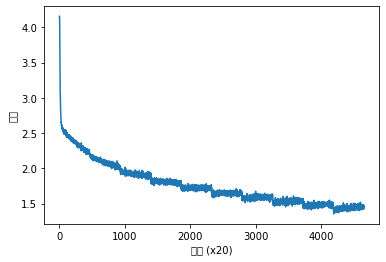

In [7]:
import sys
sys.path.append('D:/Python/14.밑바닥부터시작하는딥러닝/2/ch04')

import numpy as np
from common import config
# GPU에서 실행하려면 아래 주석을 해제하세요(CuPy 필요).
# ===============================================
GPU = False
# ===============================================
import pickle
from common.trainer import Trainer
from common.optimizer import Adam
from cbow import CBOW
from common.util import create_contexts_target, to_cpu, to_gpu
from dataset import ptb

# 하이퍼파라미터 설정
window_size = 5
hidden_size = 100
batch_size = 100
max_epoch = 10

# 데이터 읽기
corpus, word_to_id, id_to_word = ptb.load_data('train')
vocab_size = len(word_to_id)

contexts, target = create_contexts_target(corpus, window_size)
if GPU:
    contexts, target = to_gpu(contexts), to_gpu(target)

# 모델 등 생성
model = CBOW(vocab_size, hidden_size, window_size, corpus)
# model = SkipGram(vocab_size, hidden_size, window_size, corpus)
optimizer = Adam()
trainer = Trainer(model, optimizer)

# 학습 시작
trainer.fit(contexts, target, max_epoch, batch_size)
trainer.plot()

# 나중에 사용할 수 있도록 필요한 데이터 저장
word_vecs = model.word_vecs
if config.GPU:
    word_vecs = to_cpu(word_vecs)
params = {}
params['word_vecs'] = word_vecs.astype(np.float16)
params['word_to_id'] = word_to_id
params['id_to_word'] = id_to_word
pkl_file = 'cbow_params.pkl'  # or 'skipgram_params.pkl'
with open(pkl_file, 'wb') as f:
    pickle.dump(params, f, -1)

| 에폭 1 |  반복 1 / 9295 | 시간 0[s] | 손실 4.16
| 에폭 1 |  반복 21 / 9295 | 시간 1[s] | 손실 4.16
| 에폭 1 |  반복 41 / 9295 | 시간 3[s] | 손실 4.15
| 에폭 1 |  반복 61 / 9295 | 시간 5[s] | 손실 4.12
| 에폭 1 |  반복 81 / 9295 | 시간 6[s] | 손실 4.05
| 에폭 1 |  반복 101 / 9295 | 시간 8[s] | 손실 3.93
| 에폭 1 |  반복 121 / 9295 | 시간 9[s] | 손실 3.79
| 에폭 1 |  반복 141 / 9295 | 시간 11[s] | 손실 3.64
| 에폭 1 |  반복 161 / 9295 | 시간 13[s] | 손실 3.50
| 에폭 1 |  반복 181 / 9295 | 시간 14[s] | 손실 3.37
| 에폭 1 |  반복 201 / 9295 | 시간 16[s] | 손실 3.28
| 에폭 1 |  반복 221 / 9295 | 시간 18[s] | 손실 3.18
| 에폭 1 |  반복 241 / 9295 | 시간 19[s] | 손실 3.09
| 에폭 1 |  반복 261 / 9295 | 시간 21[s] | 손실 3.02
| 에폭 1 |  반복 281 / 9295 | 시간 23[s] | 손실 2.96
| 에폭 1 |  반복 301 / 9295 | 시간 25[s] | 손실 2.93
| 에폭 1 |  반복 321 / 9295 | 시간 27[s] | 손실 2.86
| 에폭 1 |  반복 341 / 9295 | 시간 30[s] | 손실 2.86
| 에폭 1 |  반복 361 / 9295 | 시간 32[s] | 손실 2.82
| 에폭 1 |  반복 381 / 9295 | 시간 34[s] | 손실 2.80
| 에폭 1 |  반복 401 / 9295 | 시간 36[s] | 손실 2.77
| 에폭 1 |  반복 421 / 9295 | 시간 38[s] | 손실 2.76
| 에폭 1 |  반복 441 / 9295

c:\Users\GIGABYTE\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:214: RuntimeWarning: Glyph 48152 missing from current font.
  font.set_text(s, 0.0, flags=flags)
c:\Users\GIGABYTE\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:214: RuntimeWarning: Glyph 48373 missing from current font.
  font.set_text(s, 0.0, flags=flags)
c:\Users\GIGABYTE\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:214: RuntimeWarning: Glyph 49552 missing from current font.
  font.set_text(s, 0.0, flags=flags)
c:\Users\GIGABYTE\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:214: RuntimeWarning: Glyph 49892 missing from current font.
  font.set_text(s, 0.0, flags=flags)
c:\Users\GIGABYTE\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:183: RuntimeWarning: Glyph 48152 missing from current font.
  font.set_text(s, 0, flags=flags)
c:\Users\GIGABYTE\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:183: RuntimeWarning: Glyph 4837

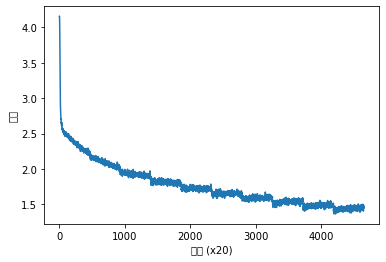

In [19]:
import sys
sys.path.append('D:/Python/14.밑바닥부터시작하는딥러닝/2/ch04')

import numpy as np
from common import config
# GPU에서 실행하려면 아래 주석을 해제하세요(CuPy 필요).
# ===============================================
GPU = True
# ===============================================
import pickle
from common.trainer import Trainer
from common.optimizer import Adam
from cbow import CBOW
from common.util import create_contexts_target, to_cpu, to_gpu
from dataset import ptb

# 하이퍼파라미터 설정
window_size = 5
hidden_size = 100
batch_size = 100
max_epoch = 10

# 데이터 읽기
corpus, word_to_id, id_to_word = ptb.load_data('train')
vocab_size = len(word_to_id)

contexts, target = create_contexts_target(corpus, window_size)
if GPU:
    contexts, target = to_gpu(contexts), to_gpu(target)
    contexts, target = contexts.get(), target.get()

# 모델 등 생성
model = CBOW(vocab_size, hidden_size, window_size, corpus)
# model = SkipGram(vocab_size, hidden_size, window_size, corpus)
optimizer = Adam()
trainer = Trainer(model, optimizer)

# 학습 시작
trainer.fit(contexts, target, max_epoch, batch_size)
trainer.plot()

# 나중에 사용할 수 있도록 필요한 데이터 저장
word_vecs = model.word_vecs
if config.GPU:
    word_vecs = to_cpu(word_vecs)
params = {}
params['word_vecs'] = word_vecs.astype(np.float16)
params['word_to_id'] = word_to_id
params['id_to_word'] = id_to_word
pkl_file = 'cbow_params.pkl'  # or 'skipgram_params.pkl'
with open(pkl_file, 'wb') as f:
    pickle.dump(params, f, -1)

3.3 CBOW 모델 평가

In [8]:
import sys
sys.path.append('D:/Python/14.밑바닥부터시작하는딥러닝/2/ch04')
from common.util import most_similar
import pickle

pkl_file = 'cbow_params.pkl'

with open(pkl_file, 'rb') as f:
    params = pickle.load(f)
    word_vecs = params['word_vecs']
    word_to_id = params['word_to_id']
    id_to_word = params['id_to_word']

querys = ['you', 'year', 'car', 'toyota']
for query in querys:
    most_similar(query, word_to_id, id_to_word, word_vecs, top=5)


[query] you
 we: 0.728515625
 i: 0.7197265625
 your: 0.6181640625
 they: 0.599609375
 us: 0.576171875

[query] year
 month: 0.853515625
 week: 0.79931640625
 spring: 0.787109375
 summer: 0.771484375
 decade: 0.68408203125

[query] car
 luxury: 0.6435546875
 cars: 0.6318359375
 truck: 0.60693359375
 window: 0.59228515625
 auto: 0.5888671875

[query] toyota
 honda: 0.66015625
 nissan: 0.64404296875
 ford: 0.6279296875
 seita: 0.6240234375
 chevrolet: 0.5986328125


### 4. word2vec 남은주제

4.1 word2vec을 사용한 애플리케이션의 예
- word2vec으로 얻은 단어의 표현은 비슷한 단어를 찾는 용도로 이용할 수 있다
- 자연어 처리 분야에서 단어의 분산표현이 중요한 이유는 전이 학습 transfer learning에 있다
- 전이학습은 한 분야에서 배운 지식을 다른 분야에도 적용하는 기법이다
- 보통 큰 말뭉치로 학습을 끝난 후, 그분산 표현을 각자의 작업에 이용하면 학습된 분산표현이 자연어 처리 작업에 대부분 훌륭한 결과를 준다
- 단어의 분산 표현은 단어를 고정 길이 벡터로 변환해준다는 장점도 있다
- 게다가 문장도 고정 길이 벡터로 변환할 수 있다
- 가장 간단한 방법은 문장의 각 단어를 분산 표현으로 변환하고 그 합을 구하는 것(bag-of-words)으로 단어의 순서를 고려하지 않는 모델. 또한 순환 신경명(RNN) 사용 문장을 고정 길이 벡터로 변환
- 구체적인 예로 메일 자동 분류시스템을 만든다면, 데이터(메일)을 수집하여 수동으로 레이블을 붙인다. 레이블링 작업이 끝나면 학습된 word2vec를 이용해 메일을 벡터로 변환하고 분류작업을 수행한다



4.2 단어의 벡터 평가 방법

- 단어의 분산 표현의 우수성을 실제 애플리케이션과는 분리해 평가하는 것이 일반적이다. 
- 이때 자주 사용되는 평가 척도가 단어의 유사성이나 유추 문제를 활용한 평가이다
- 단어의 슈사성 평가에서는 사람이 작성한 단어 유사도를 검증세트로 사용해 평가하는것이 일반적
- 유추 문제를 활용한 평가는 유추 문제를 출제하고 그 정답률(의미, 구문 등)로 단어의 분산 표현의 우수성을 측정
- 다만 분산 표현의 우수함이 애플리케이션에 얼마나 기여하는 지는 문제 상황에 따라 다르므로 주의

### 5. 정리
- Embedding 계층은 단어의 분산 표현을 담고 있으며, 순전파 시 지정한 단어 ID의 벡터를 추출한다
- word2vec은 어휘 수의 증가에 비례하여 계산량도 증가하므로, 근사치로 계산하는 빠른 기법을 사용하면 좋다
- 네거티브 샘플링은 부정적 예를 몇 개 샘플링하는 기법, 이를 이용해 다중 분류를 이진 분류처럼 취급할 수 있다
- word2vec으로 얻은 단어의 분산 표현에는 단어의 의미가 녹아들어 있으며, 비슷한 맥락에서 사용되는 단어는 단어 벡터 공간에서 가까이 위치한다
- word2vec의 단어의 분산 표현을 이용하면 유추 문제를 벡터의 덧셈과 뺄셈으로 풀 수 있게 된다
- word2vec은 전이 학습 측면에서 중요하며, 그 단어의 분산 표현은 다양한 자연어 처리 작업에 이용할 수 있다